In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset 
import os
import sys
from torch import save
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [40]:
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
from torch.utils.data import random_split

def get_data_loader(dataset, batch_size=64, val_split=0.2):
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

In [ ]:
class BanglaLekhaDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_files = []
        self.transform = transform
        self.target_transform = target_transform

        for root, _, files in os.walk(img_dir):
            for file in files:
                if file.endswith((".png", ".jpg", ".jpeg")):
                    self.img_files.append(os.path.join(root, file))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = Image.open(img_path).convert("L")

        
        img_name = os.path.basename(img_path)
        label = int(img_name.split('_')[-1].split('.')[0])

        
        label -= 1  

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label



transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


dataset = BanglaLekhaDataset(
    img_dir="/kaggle/input/banglalekha-isolated/BanglaLekha-Isolated/Images",
    transform=transform
)

 

In [6]:
class ImageClassifier(nn.Module):
    def __init__(self, num_classes=84):
        super(ImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*16*16, 128)
        self.fc2 = nn.Linear(128, num_classes) 

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
def train_model(dataset, epochs=10, lr=1e-3, device="cpu", batch_size=64):
    
    train_loader, val_loader = get_data_loader(dataset, batch_size=batch_size)

    
    model = ImageClassifier(num_classes=84).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn = CrossEntropyLoss()

    loss_history = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        epoch_loss = total_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

 
    torch.save(model.state_dict(), "model_state.pt")
    print("Training complete! Model saved as 'model_state.pt'.")

 
    import matplotlib.pyplot as plt
    plt.plot(range(1, epochs + 1), loss_history, marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()


Epoch 1/20, Loss: 1.2053
Epoch 2/20, Loss: 0.6491
Epoch 3/20, Loss: 0.4609
Epoch 4/20, Loss: 0.3215
Epoch 5/20, Loss: 0.2234
Epoch 6/20, Loss: 0.1639
Epoch 7/20, Loss: 0.1291
Epoch 8/20, Loss: 0.1068
Epoch 9/20, Loss: 0.0929
Epoch 10/20, Loss: 0.0817
Epoch 11/20, Loss: 0.0778
Epoch 12/20, Loss: 0.0699
Epoch 13/20, Loss: 0.0670
Epoch 14/20, Loss: 0.0598
Epoch 15/20, Loss: 0.0586
Epoch 16/20, Loss: 0.0540
Epoch 17/20, Loss: 0.0525
Epoch 18/20, Loss: 0.0485
Epoch 19/20, Loss: 0.0466
Epoch 20/20, Loss: 0.0435
Training complete! Model saved as 'model_state.pt'.


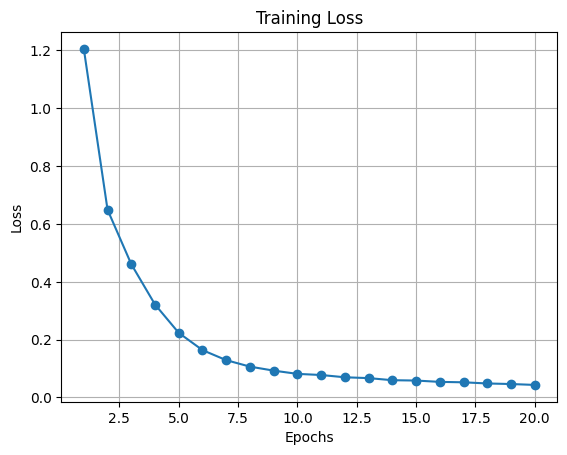

In [43]:
train_model(dataset, epochs=20, device=device, batch_size=64)

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"


model = ImageClassifier(num_classes=84).to(device)
model.load_state_dict(torch.load("model_state.pt", map_location=device))
model.eval()

ImageClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=84, bias=True)
)

In [45]:
train_loader, val_loader = get_data_loader(dataset, batch_size=64)

In [46]:
from torchmetrics.classification import MulticlassAccuracy
device = "cuda" if torch.cuda.is_available() else "cpu"

accuracy = MulticlassAccuracy(num_classes=84).to(device)
model.eval()

with torch.no_grad():
    for images, labels in val_loader:   # or test_loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        accuracy.update(preds, labels)

print(f"Test Accuracy: {accuracy.compute().item()*100:.2f}%")

Test Accuracy: 95.53%


In [70]:
label_map = {
    0: "অ",
    1: "আ",
    2: "ই",
    3: "ঈ",
    4: "উ",
    5: "ঊ",
    6: "ঋ",
    7: "এ",
    8: "ঐ",
    9: "ও",
    10: "ঔ",
    11: "ক",
    12: "খ",
    13: "গ",
    14: "ঘ",
    15: "ঙ",
    16: "চ",
    17: "ছ",
    18: "জ",
    19: "ঝ",
    20: "ঞ",
    21: "ট",
    22: "ঠ",
    23: "ড",
    24: "ঢ",
    25: "ণ",
    26: "ত",
    27: "থ",
    28: "দ",
    29: "ধ",
    30: "ন",
    31: "প",
    32: "ফ",
    33: "ব",
    34: "ভ",
    35: "ম",
    36: "য",
    37: "র",
    38: "ল",
    39: "শ",
    40: "ষ",
    41: "স",
    42: "হ",
    43: "ড়",
    44: "ঢ়",
    45: "য়",
    46: "ৎ",
    47: "ং",
    48: "ঃ",
    49: "ঁ",
    50: "০",
    51: "১",
    52: "২",
    53: "৩",
    54: "৪",
    55: "৫",
    56: "৬",
    57: "৭",
    58: "৮",
    59: "৯",
    60: "ক্ষ",
    61: "ব্দ",
    62: "ঙ্গ",
    63: "স্ক",
    64: "স্ফ",
    65: "স্থ",
    66: "চ্ছ",
    67: "ক্ত",
    68: "স্ন",
    69: "ষ্ণ",
    70: "ম্প",
    71: "হ্ম",
    72: "প্ত",
    73: "ম্ব",
    74: "ন্ড",
    75: "দ্ভ",
    76: "ত্থ",
    77: "ষ্ঠ",
    78: "ল্প",
    79: "ষ্প",
    80: "ন্দ",
    81: "ন্ধ",
    82: "ন্ম",
    83: "ণ্ঠ"
}

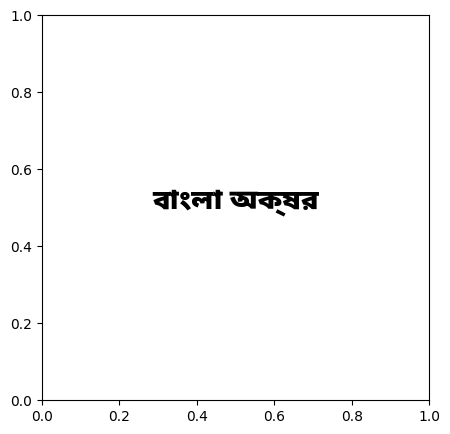

In [68]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


bengali_font = fm.FontProperties(fname="/kaggle/input/noto-sans-bengali/static/NotoSansBengali-Black.ttf")


plt.figure(figsize=(5, 5))
plt.text(0.5, 0.5, "বাংলা অক্ষর", fontproperties=bengali_font, fontsize=20, ha='center')
plt.show()


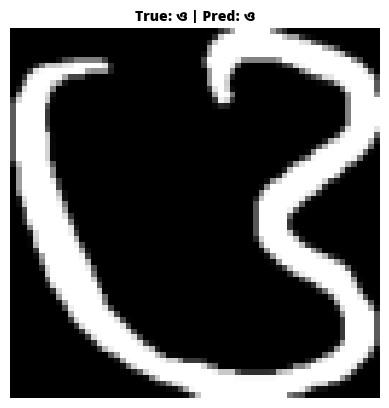

In [72]:
import random
from matplotlib import font_manager as fm



model.eval()
images, labels = next(iter(val_loader))
idx = random.randint(0, len(images)-1)
img, label = images[idx].to(device), labels[idx].to(device)

output = model(img.unsqueeze(0))
pred = output.argmax(dim=1).item()

plt.imshow(img.cpu().squeeze(), cmap="gray")
plt.title(f"True: {label_map[label.item()]} | Pred: {label_map[pred]}", fontproperties=bengali_font)
plt.axis("off")
plt.show()


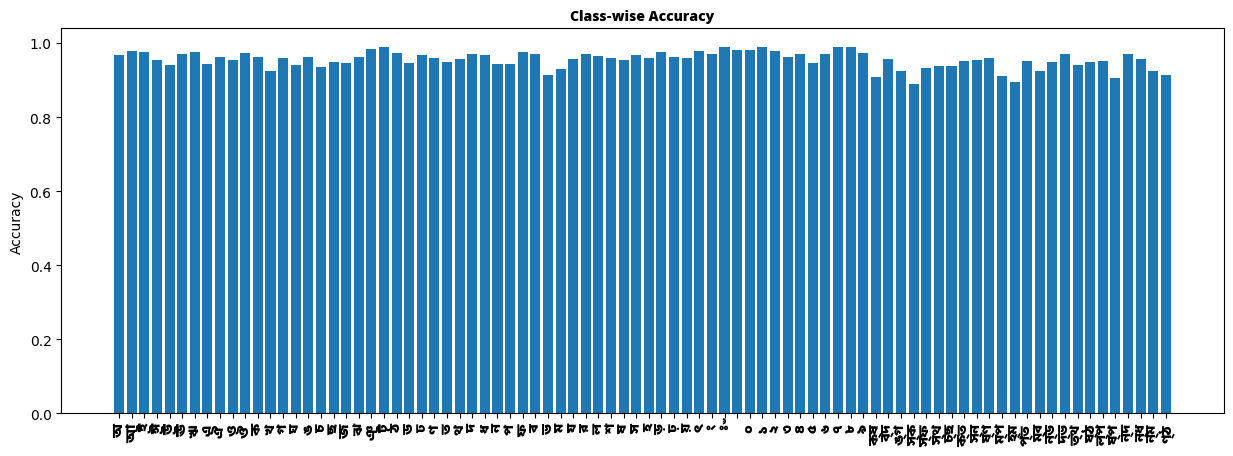

In [78]:
class_acc = np.diag(cm)/np.sum(cm, axis=1)  
plt.figure(figsize=(15,5))
plt.bar(range(84), class_acc)
plt.xticks(range(84), [label_map[i] for i in range(84)], rotation=90, fontproperties=bengali_font)
plt.title("Class-wise Accuracy", fontproperties=bengali_font)
plt.ylabel("Accuracy")
plt.show()